In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import process 


2024-12-17 19:45:28.901296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-17 19:45:28.915493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734486328.933280  834366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734486328.938390  834366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-17 19:45:28.956835: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Nibabel

In [174]:
import nibabel as nib
import os
import glob

import process 


ppdata_path = '/media/large_ssd/ab126/OpenNeuro/ppdata'
paths = os.listdir(ppdata_path)

nifti_rel_path = '/func1pt8mm/timeseries'
nifti_path = ppdata_path + '/subj03' +  nifti_rel_path
for pth in glob.glob(nifti_path + '/*'):
    img_file = nib.load(pth)
    #img_file = process.load_nifti(pth)
    print(img_file.shape)
    tmp = pth

(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82, 226)
(81, 106, 82

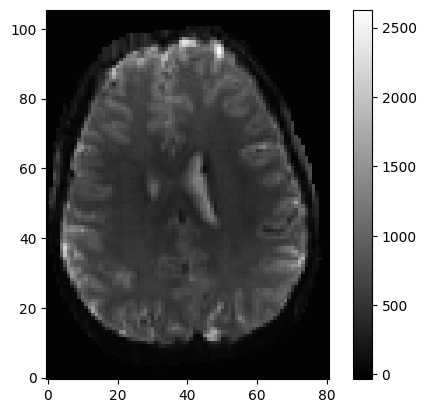

In [175]:
import matplotlib.pyplot as plt


orig_img_data = img_file.get_fdata()
plt.imshow(orig_img_data[:,:, 53, 0].T, cmap='gray', origin='lower') # Transposing gives MNI coord system
plt.colorbar()

In [98]:
f_img_data.dtype, f_img_data.shape

(dtype('float64'), (81, 106, 82, 226))

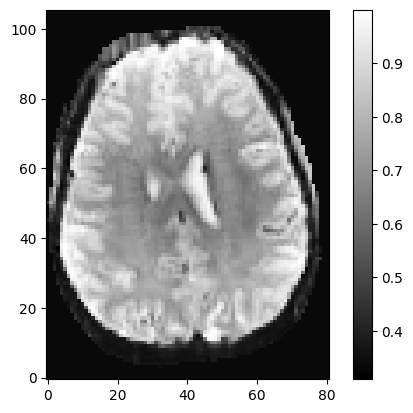

In [180]:
f_img_data = process.load_nifti(tmp)

plt.imshow(f_img_data[0, :, :, 53], cmap='gray', origin='lower') 
plt.colorbar()


# Load Data

In [34]:
import process

import importlib
importlib.reload(process)

from process import fMRIDataset

In [35]:


batch_size = 30
ppdata_path = '/media/large_ssd/ab126/OpenNeuro/NSDDataset/ppdata'
nifti_rel_path = '/func1pt8mm/timeseries'
numpy_rel_path = '/func1pt8mm/numpy'
single_subject = 'subj04'
data_handler = fMRIDataset(ppdata_path, nifti_rel_path=nifti_rel_path, numpy_rel_path=numpy_rel_path, batch_size=batch_size,
                           single_subject=single_subject)

In [36]:
data_handler.precompute_nifti2numpy(only_indices=True)

1st pass 

Subject subj04
timeseries_session02_run02.nii.gz
Done


In [37]:
data_handler.subj_tot_samples

{'subj04': 88592}

In [38]:
data_handler.__len__(), data_handler.subject_inds

(3136, [('subj04', 0)])

In [9]:
data_handler.precompute_nifti2numpy()

1st pass 

Subject subj04
timeseries_session02_run02.nii.gz
Done

2nd pass 

Subject subj04
Done


In [10]:
def_size = (226, 96, 84, 80, 1)
for batch, lbl in data_handler:
    print(batch.shape)
    if def_size != batch.shape:
        break

(30, 96, 80, 80, 1)


In [11]:
batch.shape

(30, 96, 80, 80, 1)

# Model

In [204]:
import process

import importlib
importlib.reload(process)

from process import NSDDataset

In [102]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv3D, Conv3DTranspose, BatchNormalization, MaxPooling3D, UpSampling3D, Flatten, Activation
from keras import losses

# Encoder
encoder = Sequential()
encoder.add(Input(shape=( 96, 80, 80, 1)))

encoder.add(Conv3D(8, kernel_size=(5, 5, 5), padding="same"))
#encoder.add(BatchNormalization())
encoder.add(Activation('relu'))

encoder.add(MaxPooling3D(2))

encoder.add(Conv3D(16, kernel_size=(5, 5, 5), padding="same"))
#encoder.add(BatchNormalization())
encoder.add(Activation('relu'))

encoder.add(MaxPooling3D(2))

encoder.add(Conv3D(32, kernel_size=(5, 5, 5), padding="same"))
#encoder.add(BatchNormalization())
encoder.add(Activation('relu'))

encoder.add(MaxPooling3D(2))

# Dense Layers
"""
encoder.add(Flatten())

encoder.add(Dense(1024))
encoder.add(Activation('relu'))

encoder.add(Dense(16))
encoder.add(Activation('relu'))
"""

# Reshape

# Decoder
decoder = Sequential()

decoder.add(Conv3DTranspose(32, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('relu'))

decoder.add(UpSampling3D(2))

decoder.add(Conv3DTranspose(16, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('relu'))

decoder.add(UpSampling3D(2))

decoder.add(Conv3DTranspose(8, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('relu'))

decoder.add(UpSampling3D(2))

decoder.add(Conv3D(1, kernel_size=5, padding="same"))
#decoder.add(BatchNormalization())
decoder.add(Activation('sigmoid'))


autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 12, 10, 10, 32) │        81,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 96, 80, 80, 1)  │       209,057 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,113 (1.11 MB)

 Trainable params: 290,113 (1.11 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 96, 80, 80, 8)  │         1,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 96, 80, 80, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 48, 40, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 48, 40, 40, 16) │        16,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 48, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 24, 20, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 24, 20, 20, 32) │        64,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 24, 20, 20, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 12, 10, 10, 32) │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,056 (316.62 KB)

 Trainable params: 81,056 (316.62 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_transpose_6              │ (None, 12, 10, 10, 32) │       128,032 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 12, 10, 10, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_6 (UpSampling3D)  │ (None, 24, 20, 20, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_7              │ (None, 24, 20, 20, 16) │        64,016 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 24, 20, 20, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_7 (UpSampling3D)  │ (None, 48, 40, 40, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_transpose_8              │ (None, 48, 40, 40, 8)  │        16,008 │
│ (Conv3DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 48, 40, 40, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_8 (UpSampling3D)  │ (None, 96, 80, 80, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 96, 80, 80, 1)  │         1,001 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 96, 80, 80, 1)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,057 (816.63 KB)

 Trainable params: 209,057 (816.63 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
data_handler.__len__()

3136

In [124]:
import numpy as np

n_total = data_handler.__len__()
n_train = int(np.ceil( n_total* 0.8))
print(n_train, n_total)
train_handler = fMRIDataset(ppdata_path, nifti_rel_path=nifti_rel_path, numpy_rel_path=numpy_rel_path, batch_size=batch_size)
train_handler.precompute_nifti2numpy(only_indices=True)
train_handler.set_len(n_train)
print("Train size: {}".format(train_handler.__len__()))

val_handler = fMRIDataset(ppdata_path, nifti_rel_path=nifti_rel_path, numpy_rel_path=numpy_rel_path, batch_size=batch_size, batch_offset=n_train)
val_handler.precompute_nifti2numpy(only_indices=True)
val_handler.set_len(n_total - n_train)
print("Test size: {}".format(val_handler.__len__()))

2509 3136


NameError: name 'fMRIDataset' is not defined

In [105]:
checkpoint_path = "saves/training_2/cp.weights.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)

#train_handler, val_handler = tf.keras.utils.split_dataset(data_handler, right_size=0.2)
#history = autoencoder.fit(train_handler, epochs=10, shuffle=True, validation_data=val_handler, callbacks=[cp_callback])
history = autoencoder.fit(data_handler, epochs=10, shuffle=True, callbacks=[cp_callback])

Epoch 1/10


E0000 00:00:1734319217.006493 2111629 buffer_comparator.cc:157] Difference at 0: 2.30055e+06, expected 2.06895e+06
E0000 00:00:1734319217.021095 2111629 buffer_comparator.cc:157] Difference at 1: 2.33089e+06, expected 2.0963e+06
E0000 00:00:1734319217.021119 2111629 buffer_comparator.cc:157] Difference at 2: 2.36046e+06, expected 2.11815e+06
E0000 00:00:1734319217.021131 2111629 buffer_comparator.cc:157] Difference at 3: 2.33262e+06, expected 2.09779e+06
E0000 00:00:1734319217.021143 2111629 buffer_comparator.cc:157] Difference at 4: 2.30498e+06, expected 2.07403e+06
E0000 00:00:1734319217.021177 2111629 buffer_comparator.cc:157] Difference at 5: 2.33253e+06, expected 2.09718e+06
E0000 00:00:1734319217.021185 2111629 buffer_comparator.cc:157] Difference at 6: 2.35953e+06, expected 2.11671e+06
E0000 00:00:1734319217.021192 2111629 buffer_comparator.cc:157] Difference at 7: 2.39492e+06, expected 2.14328e+06
E0000 00:00:1734319217.021200 2111629 buffer_comparator.cc:157] Difference at 8: 

   1/3136 ━━━━━━━━━━━━━━━━━━━━ 10:07:49 12s/step - loss: 0.0406

2024-12-15 21:20:23.028666: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[30,1,96,80,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[30,8,96,80,80]{4,3,2,1,0}, f32[1,8,5,5,5]{4,3,2,1,0}, f32[1]{0}), window={size=5x5x5 pad=2_2x2_2x2_2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-15 21:20:23.205320: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.176833859s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[30,1,96,80,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[30,8,96,80,80]{4,3,2,1,0}, f32[1,8,5,5,5]{4,3,2,1,0}, f32[1]{0}), window={size=5x5x5 pad=2_2x2_2x2_2}, dim_labels=bf012_oi012->bf012, custom_call_target=

  49/3136 ━━━━━━━━━━━━━━━━━━━━ 30:17 589ms/step - loss: 0.0394

E0000 00:00:1734319259.114384 2111632 buffer_comparator.cc:157] Difference at 0: 3.59077e+06, expected 2.99973e+06
E0000 00:00:1734319259.114511 2111632 buffer_comparator.cc:157] Difference at 1: 3.64059e+06, expected 3.03679e+06
E0000 00:00:1734319259.114514 2111632 buffer_comparator.cc:157] Difference at 2: 3.68492e+06, expected 3.07054e+06
E0000 00:00:1734319259.114520 2111632 buffer_comparator.cc:157] Difference at 3: 3.63794e+06, expected 3.03538e+06
E0000 00:00:1734319259.114525 2111632 buffer_comparator.cc:157] Difference at 4: 3.59169e+06, expected 3.0018e+06
E0000 00:00:1734319259.114528 2111632 buffer_comparator.cc:157] Difference at 5: 3.6398e+06, expected 3.03574e+06
E0000 00:00:1734319259.114531 2111632 buffer_comparator.cc:157] Difference at 6: 3.68316e+06, expected 3.06789e+06
E0000 00:00:1734319259.114533 2111632 buffer_comparator.cc:157] Difference at 7: 3.73522e+06, expected 3.10825e+06
E0000 00:00:1734319259.114536 2111632 buffer_comparator.cc:157] Difference at 8: 3

3136/3136 ━━━━━━━━━━━━━━━━━━━━ 938s 295ms/step - loss: 0.0098
Epoch 2/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1016s 324ms/step - loss: 0.0021
Epoch 3/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1011s 322ms/step - loss: 0.0017
Epoch 4/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1120s 357ms/step - loss: 0.0015
Epoch 5/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1504s 479ms/step - loss: 0.0014
Epoch 6/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1417s 452ms/step - loss: 0.0013
Epoch 7/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1424s 454ms/step - loss: 0.0013
Epoch 8/10
3136/3136 ━━━━━━━━━━━━━━━━━━━━ 1493s 476ms/step - loss: 0.0013
Epoch 9/10
 191/3136 ━━━━━━━━━━━━━━━━━━━━ 22:22 456ms/step - loss: 0.0013

2024-12-16 00:06:57.879191: W tensorflow/core/framework/op_kernel.cc:1829] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: '/media/large_ssd/ab126/OpenNeuro/ppdata/subj04/func1pt8mm/numpy'
Traceback (most recent call last):

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self.py_dataset[i]

  File "/

 194/3136 ━━━━━━━━━━━━━━━━━━━━ 22:26 458ms/step - loss: 0.0013

2024-12-16 00:06:59.681486: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5015190900746120441
2024-12-16 00:06:59.681752: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 3893816904105276616


UnknownError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/media/large_ssd/ab126/OpenNeuro/ppdata/subj04/func1pt8mm/numpy'
Traceback (most recent call last):

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self.py_dataset[i]

  File "/home/ab126/PycharmProjects/ELEC-576/Project/process.py", line 183, in __getitem__
    numpy_path = self.ppdata_path + '/' + subject + self.numpy_rel_path

FileNotFoundError: [Errno 2] No such file or directory: '/media/large_ssd/ab126/OpenNeuro/ppdata/subj04/func1pt8mm/numpy'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '/media/large_ssd/ab126/OpenNeuro/ppdata/subj04/func1pt8mm/numpy'
Traceback (most recent call last):

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py", line 248, in _finite_generator
    yield self.py_dataset[i]

  File "/home/ab126/PycharmProjects/ELEC-576/Project/process.py", line 183, in __getitem__
    numpy_path = self.ppdata_path + '/' + subject + self.numpy_rel_path

FileNotFoundError: [Errno 2] No such file or directory: '/media/large_ssd/ab126/OpenNeuro/ppdata/subj04/func1pt8mm/numpy'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_751210]

In [26]:
train_handler.subject_inds

[('subj04', 0)]

In [23]:
for batch, _ in train_handler:
    print(batch.shape)

(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(16, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(16, 96, 80, 80, 1)
(16, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(16, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(16, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)
(30, 96, 80, 80, 1)


In [24]:
len(train_handler)

3136

In [1]:
plt.plot(history.history['loss'])
plt.ylabel('MSE loss')
plt.xlabel('epoch')


NameError: name 'plt' is not defined

In [28]:
# Manually save
autoencoder.save_weights(checkpoint_path)


In [113]:
model_path = "saves/autoencoder_cnn_3deep_b30_8_16_32.keras"
autoencoder.save(model_path)

In [115]:
import copy

arch_autoerncoder = copy.deepcopy(autoencoder)

In [39]:
# Load previous models
model_path = "saves/autoencoder_cnn_3deep_b30_8_16_32.keras"#"saves/autoencoder_cnn_only.keras"#"saves/autoencoder_cnn_only.keras"
autoencoder = tf.keras.models.load_model(model_path)
#autoencoder.load_weights(checkpoint_path)
#autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [69]:
autoencoder.evaluate(data_handler)

  62/3136 ━━━━━━━━━━━━━━━━━━━━ 7:17 142ms/step - loss: 0.3606

Exception ignored in: <function AtomicFunction.__del__ at 0x7fe7e3d445e0>
Traceback (most recent call last):
  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/eager/polymorphic_function/atomic_function.py", line 286, in __del__
    def __del__(self):
KeyboardInterrupt: 


 140/3136 ━━━━━━━━━━━━━━━━━━━━ 7:12 144ms/step - loss: 0.3609

KeyboardInterrupt: 

# Interpretation

## Layer activations

In [118]:
conv_layer_weights = autoencoder.get_weights()[0]

In [119]:
conv_layer_weights.shape

(5, 5, 5, 1, 8)

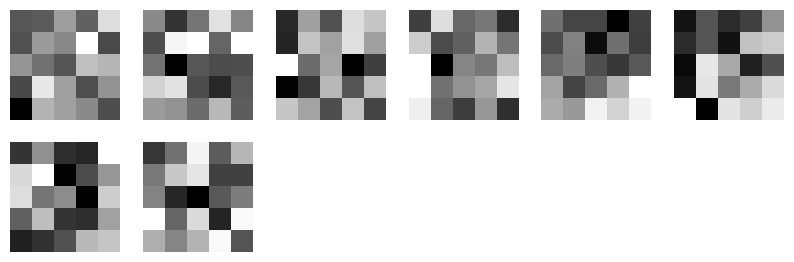

In [120]:

plt.figure(figsize=(10, 10))
for i in range(conv_layer_weights.shape[-1]):
    plt.subplot(6, 6, i+1)
    plt.imshow(conv_layer_weights[0, :, :, 0, i], cmap='gray')
    plt.axis('off')
plt.show()

## Sample reconstructions

In [150]:
x.shape, x_hat.shape

((10, 104, 84, 84, 1), (10, 104, 84, 84, 1))

In [41]:
x = data_handler[64][0]
x_hat = autoencoder.predict(x)

z = 50
t = 5

fig = plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x[t, : ,:, z, 0], cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 2, 2)
plt.imshow(x_hat[t, : ,:, z, 0], cmap='gray')
plt.title("Reconstructed")
fig.suptitle("z={}".format(z), y=0.9)
plt.tight_layout()

2024-12-17 21:30:18.036616: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 648.82MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-17 21:30:18.036692: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 648.82MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-17 21:30:18.036706: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 648.82MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-12-17 21:30:18.036716: W external/local_xla/

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_834366/2235952259.py", line 2, in <module>

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 559, in predict

  File "/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 256, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.12 = (f32[30,8,96,80,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[30,1,96,80,80]{4,3,2,1,0} %bitcast.211, f32[8,1,5,5,5]{4,3,2,1,0} %bitcast.350, f32[8]{0} %arg2.3), window={size=5x5x5 pad=2_2x2_2x2_2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv3D" op_name="sequential_8_1/sequential_6_1/conv3d_8_1/convolution" source_file="/home/ab126/PycharmProjects/ELEC-576/tf/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1196}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}

Original error: INTERNAL: All algorithms tried for (f32[30,8,96,80,80]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[30,1,96,80,80]{4,3,2,1,0}, f32[8,1,5,5,5]{4,3,2,1,0}, f32[8]{0}), window={size=5x5x5 pad=2_2x2_2x2_2}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} failed. Falling back to default algorithm.  Per-algorithm errors:
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 680333232 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 680333232 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 680333232 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 34766848 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_1174]